# **Global Sentiment**

Este es el notebook que usaremos para el scrapeo de datos


In [3]:
import datetime
from datetime import timedelta

import os
import re

import snscrape.modules.twitter as snstwitter

import pandas as pd
import seaborn as sns
import numpy as np

## **Parameter Settings**

In [4]:
date_init = "2017-01-02"
date_limit = "2021-02-15"

## **Read Databases**

In [5]:
t_path = "JABA/data/tweets"
t_file = "tweet_list.csv"
s_file = "tweet_sentiment_nltk.csv"

La base de datos esta formada por millones de filas y no usaremos todas las columnas, por lo que, para acelerar el proceso, eliminaremos las columnas no usadas.

En este caso, ademas, la columna Text, es la columna con mayor peso en memoria, por lo que eliminarla aligerara la carga en RAM.

In [6]:
unused_columns = ['Text', 'Tweet Id', 'NumReplies', 'NumRetweets', 'IDOriginalRetweeted', 'isVerified'  ]

def drop_unused_columns(dataframe):
    return dataframe.drop(unused_columns,  axis=1)

def get_data():
    subfolders = [ f.path for f in os.scandir(t_path) if f.is_dir() ]
    frames = []

    for i, folder in enumerate(subfolders):
        # Para saltarse carpetas ocultas
        if "." in folder:
            continue

        if folder == "JABA/data/tweets\\" + date_limit:
            break

        if i%300 == 0:
            print(f"Step {i} : {folder}")

        tweet_file = os.path.join(folder, t_file)
        sentiment_file = os.path.join(folder, s_file)

        tweet_df = pd.read_csv(tweet_file, sep=";")
        tweet_df = drop_unused_columns(tweet_df)

        sent_df = pd.read_csv(sentiment_file, sep=";")

        tweet_df = tweet_df.join(sent_df)

        frames += [tweet_df]


    return pd.concat(frames, ignore_index=True)
    

In [8]:
df = get_data()
df["Datetime"] = pd.to_datetime(df["Datetime"]) 

Step 300 : JABA/data/tweets\2017-06-02
Step 600 : JABA/data/tweets\2018-03-29
Step 900 : JABA/data/tweets\2019-01-23
Step 1200 : JABA/data/tweets\2019-11-19
Step 1500 : JABA/data/tweets\2020-09-16


## **Sentimiento Global**

A la hora de trabajar con el sentimiento, se observa que el sentimiento de un grupo de personas no debería ser medido mediante la media de todos sus individuos. Al fin y al cabo, ¿es lo mismo que sea positivo para 100 personas que para 1 millón?

Además de esto, es importante darse cuenta de que un mensaje positivo no es igual/tiene el mismo valor salga de quien salga. Un tweet bueno de Elon Musk vale mucho más que un tweet bueno de una cuenta sin likes. Por ello, estos deberían afectar a la valuación del sentimiento. 

In [9]:
df['sentiment_v'] = ( 1 + np.log2(1 + df['NumLikes']) ) * df['sentiment'] 

Ya que el sentimiento tendremos que agregarlo para que tenga una utilidad, añadiremos una columna con el tiempo agrupado.

In [10]:
df["rount_datetime"] = df["Datetime"].dt.floor("30T")

## **Sentimiento Global con Ponderación por Usuario**

In [36]:
test_df = df[1:5000]

In [38]:
tg_test_sum = test_df.groupby(['rount_datetime', 'Username']).agg({'sentiment_v' : 'sum' , 'Datetime':'count'})

In [43]:
tg_test_sum['cum'] = np.log2(1+tg_test_sum['Datetime']) / tg_test_sum['Datetime'] * tg_test_sum['sentiment_v']

In [45]:
tg_test_sum = tg_test_sum.groupby('rount_datetime').sum()

In [123]:

tg_test_count = df.groupby(['rount_datetime', 'Username']).count()
tg_test =pd.merge(tg_test_sum, tg_test_count, how='inner', left_index=True, right_index=True)

In [124]:
tg_test['cum'] = np.log2(1+tg_test['NumLikes_y']) / tg_test['NumLikes_y'] * tg_test['sentiment_v']

In [125]:
tg_test = tg_test.groupby('rount_datetime').sum()

In [126]:
tg_test.index = tg_test.index.tz_localize(None)

In [132]:
tg_test = tg_test['2017-01-02':date_limit]

In [81]:
df.set_index('Datetime')
df.index = df.index.tz_localize(None)

RangeIndex(start=0, stop=17036819, step=1)

## **Get Bitcoin Data**

In [11]:
b_path = "JABA/data/bitcoin"
b_file = "bitcoin.csv"

b_limit = date_limit

In [12]:
btc_df = pd.read_csv("bitcoinData1M.csv", sep=",")
btc_df['Timestamp'] = pd.to_datetime(btc_df['Timestamp'], unit='s')
btc_df = btc_df.drop(['Open','High','Low','Weighted_Price','Volume_(BTC)', 'Volume_(Currency)'], axis=1)

In [13]:
btc_df['timestamp_round'] = btc_df['Timestamp'].dt.floor('30T')
btc_df = btc_df.set_index('Timestamp')
btc_df = btc_df.fillna(0)

In [ ]:
b_subfolders = [ f.path for f in os.scandir(b_path) if f.is_dir() ]

btc_df = pd.DataFrame()
first = True

for i, folder in enumerate(b_subfolders):
    if folder == b_path+ "\\" + b_limit:
        break
    if i%30 == 0:
        print(f"Step {i} : {folder}")
        
    bt_file = os.path.join(folder, b_file)
    
    b_df = pd.read_csv(bt_file, sep=";")
    
    btc_df = pd.concat([btc_df,b_df])

## **Preparar Datos**

In [16]:
df_gb = df.groupby("rount_datetime").sum()
#df_gb_c = df.groupby('rount_datetime').nunique()
btc_df = btc_df.groupby("timestamp_round").mean()

In [17]:
btc_df = btc_df[date_init:date_limit]
df_gb = df_gb[date_init:date_limit]
#df_gb_c = df_gb_c[date_init:date_limit]

In [19]:
del df

In [18]:
btc_df.index = btc_df.index.tz_localize(None)
#df_gb_c.index = df_gb_c.index.tz_localize(None)
df_gb.index = df_gb.index.tz_localize(None)

In [20]:
merge = pd.merge(df_gb,btc_df, how='inner', left_index=True, right_index=True)
#merge = pd.merge(merge,df_gb_c, how='inner', left_index=True, right_index=True)

In [21]:
merge.head()

,NumLikes,sentiment,sentiment_v,Close
2017-01-02 00:00:00,108,39.5273,64.974757,632.150333
2017-01-02 00:30:00,161,41.6143,60.986679,465.710667
2017-01-02 01:00:00,324,26.2522,41.555880,698.435000
2017-01-02 01:30:00,405,29.3276,44.695415,698.766667
2017-01-02 02:00:00,354,31.4892,42.712867,665.699667


In [20]:
merge['sentiment_val'] = merge['sentiment_x'] * merge['Username'] * np.log(merge['Tweet Id_y'] / merge['Username'])

## Correlation

<AxesSubplot:>

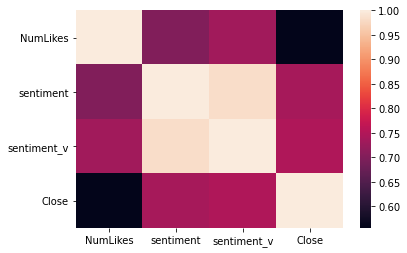

In [32]:
sns.heatmap(merge.corr())

In [39]:
merge['sentiment_v'].corr(merge['Close'])

0.7477097998735797

In [ ]:
coor_data = []

corr_index_range = 100

for i in range(-corr_index_range,corr_index_range):
    merge2 = merge.shift(periods=i)
    #print(f"Con shift %i el corr es %.4f " % (i, merge2['sentiment_zz'].corr(merge['Close'])))
    coor_data += [merge2['sentiment_zz'].corr(merge['Close'])]


print(f"Index of the max corr {-corr_index_range+coor_data.index(max(coor_data))}")
print(f"Max corr {max(coor_data)}")

sns.lineplot(range(-100,100),coor_data)

In [193]:
tg_test['NumLikes_y2'] = tg_test['NumLikes_y2'] * 0.95

In [158]:
merge['sentiment_v2'] = merge['sentiment_v2'] * 1.2

In [107]:
import matplotlib.pyplot as plt

Text(0, 0.5, 'Price (USD)')

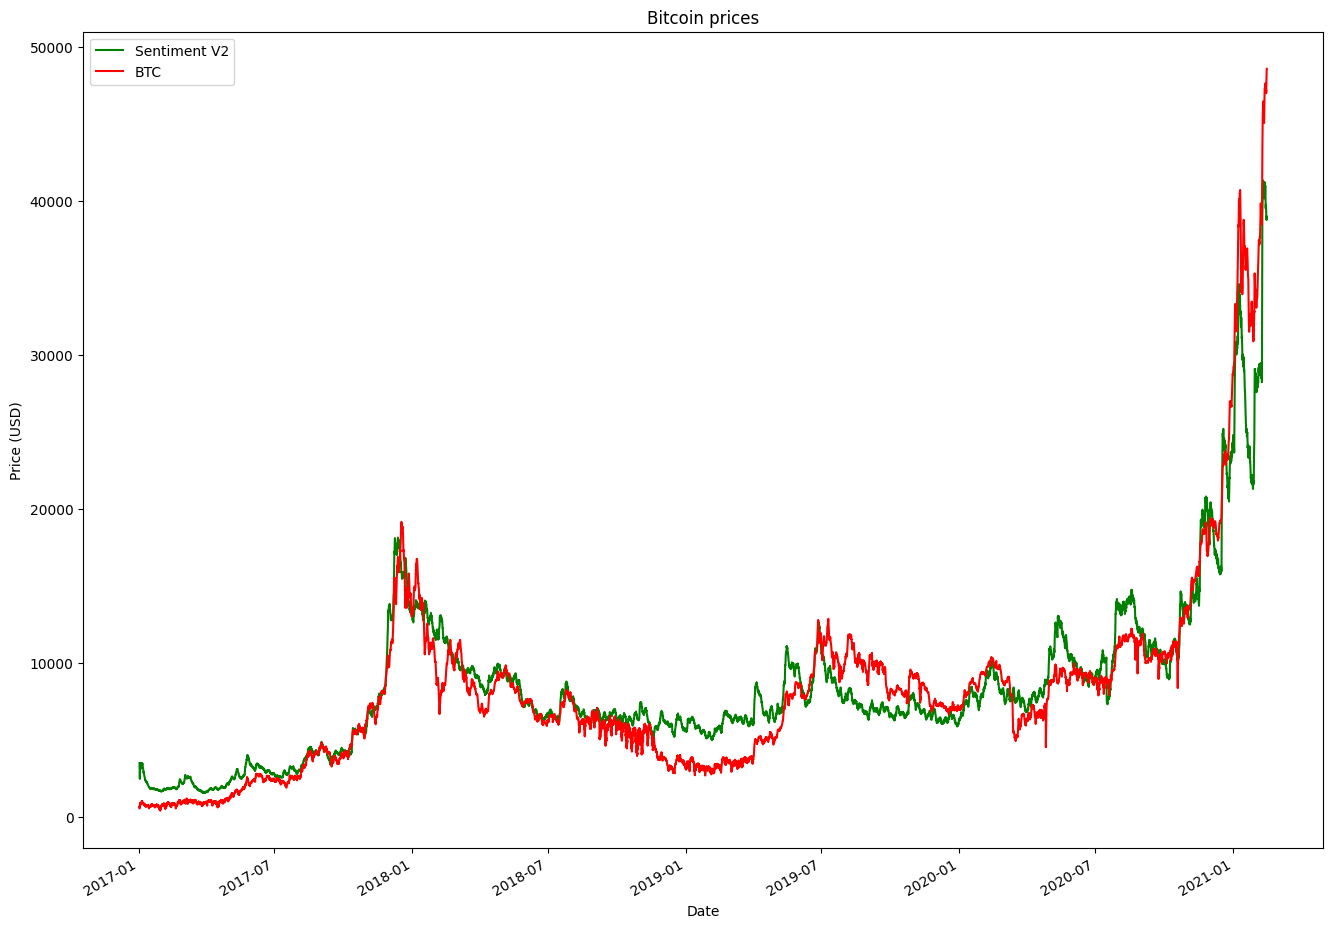

In [165]:
merge['sentiment_zz'].ewm(span = 500).mean().plot(style = 'g', label = 'Sentiment V2')
merge['sentiment_v2'].ewm(span = 500).mean().plot(style = 'b', label = 'Sentiment')
merge['Close'].ewm(span = 40).mean().plot(style = 'r', label = 'BTC')

plt.rcParams['figure.figsize'] = [16, 12]
plt.rcParams['figure.dpi'] = 100
plt.legend()
plt.title("Bitcoin prices")
plt.xlabel('Date')
plt.ylabel('Price (USD)')

In [ ]:
merge['sentiment_zz'].ewm(span = 300).mean().plot(style = 'b', label = 'Sentiment')
merge['close'].ewm(span = 30).mean().plot(style = 'r', label = 'BTC')

plt.rcParams['figure.figsize'] = [16, 12]
plt.rcParams['figure.dpi'] = 100
plt.legend()
plt.title("Bitcoin prices")
plt.xlabel('Date')
plt.ylabel('Price (USD)')

## **ARIMA**

In [61]:
import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA

model=ARIMA(merge['Close'],order=(1, 1,1 ))


results=model.fit()


NameError: name 'AutoReg' is not defined

In [ ]:
from statsmodels.tsa.ar_model import AutoReg

model=AutoReg(merge['Close'], lags=12000)


results=model.fit()



In [ ]:
from pandas.tseries.offsets import DateOffset

#future_df['close'] = future_df['close'].fillna(0)
result_data = results.predict(start = 71881, end = 82001, dynamic= False)
pd.concat([merge['Close'], result_data[236:]]).plot(figsize=(12, 8))

In [53]:
len(merge['Close'])

71881

## Linear regression

No vale de nada, pero es para probar un poco.

In [22]:
import numpy as np
from sklearn.linear_model import LinearRegression

In [26]:
reg = LinearRegression().fit(merge[['Close']].to_numpy(), merge['sentiment_v'].to_numpy())

In [29]:
reg.score(merge[['Close']].to_numpy(), merge['sentiment_v'].to_numpy())

0.5590699448269882